# 데이터 준비와 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터로더 구성

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
    train_data = train_data.dropna(how = 'any') # 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
    test_data = test_data.dropna(how = 'any') #결측치 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 사전 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) # 데이터의 개수가 많은 순으로 정렬된 배열을 리턴
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

pandas 메소드 .drop_duplicates(subset=None, keep='first', inplace=False) 설명

subset은 중복데이터를 처리할 열을 입력 받는다.

keep은 중복데이터 발견 시 어떤 데이터를 마크/삭제할 지 결졍한다.('first'=처음 발견된 데이터를 제외하고 삭제)

inplace는 메소드가 적용되는 원본 데이터를 변경할지 여부를 결정한다.(True=변경한다.)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델 구성을 위한 데이터 분석 및 가공

In [5]:
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print(X_train[0])
print('')
print('7번째 리뷰 문장 길이: ', len(X_train[7]))
print(X_train[7])

1번째 리뷰 문장 길이:  10
[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

7번째 리뷰 문장 길이:  43
[232, 1450, 144, 6, 425, 756, 2, 2, 52, 1532, 290, 99, 250, 4, 4, 28, 855, 29, 353, 652, 540, 509, 583, 6, 3318, 4, 8895, 22, 1460, 1460, 4, 4, 71, 304, 17, 6, 52, 104, 8, 77, 22, 2, 43]


In [6]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 지정 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('\npad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
# padding 넣기
import tensorflow as tf
from tensorflow import keras

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


RNN은 입력데이터가 순차적으로 처리되어, 최후 입력이 최종 state값에 가장 영향을 많이 미친다.

그러므로 'pre'가 훨씬 유리한데, 최후 입력이 무의미한 패딩으로 채워지는 것은 비효율적이기 때문이다.

In [8]:
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print(X_train[0])
print('')
print('7번째 리뷰 문장 길이: ', len(X_train[7]))
print(X_train[7])

1번째 리뷰 문장 길이:  41
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]

7번째 리뷰 문장 길이:  41
[ 144    6  425  756    2    2   52 1532  290   99  250    4    4   28
  855   29  353  652  540  509  583    6 3318    4 8895   22 1460 1460
    4    4   71  304   17    6   52  104    8   77   22    2   43]


패딩을 거친 뒤

길이가 41보다 짧은 문장은 41에 맞춰 0이 채워지고, 길이가 41보다 긴 문장은 41에 맞춰 길이가 잘린다.

위에서 X_train의 길이는 10이었는데 (padding='pre'옵션을 주었기 때문에)앞에 0을 채워 41이 되었고, X_train[7]의 길이는 43이었는데 앞의 232, 1450이 잘리면서 41로 맞춰진 것을 알 수 있다.

+) 퍼실님의 말씀에 따르면 영어와 한국어의 어순 차이(각각 두괄식, 미괄식)때문에

영어는 post(최대 길이보다 긴 문장은 패딩 과정에서 뒷부분이 잘림), 한국어는 pre(~앞부분이 잘림)를 선택하기도 한다.

# 모델 구성

### RNN 모델 - LSTM 레이어 사용

In [9]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

RNN_model = tf.keras.Sequential()
RNN_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
RNN_model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
RNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
RNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

RNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 1D CNN 모델

In [10]:
# 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식
# CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행
vocab_size = 10000
word_vector_dim = 16

CNN_model = tf.keras.Sequential()
CNN_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.MaxPooling1D(5))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.GlobalMaxPooling1D())
CNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
CNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### GlobalMaxPooling1D() 레이어 하나만 사용

In [11]:
# GlobalMaxPooling1D() 레이어 하나만 사용
# 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식
vocab_size = 10000
word_vector_dim = 16

GMP_model = tf.keras.Sequential()
GMP_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(tf.keras.layers.GlobalMaxPooling1D())
GMP_model.add(tf.keras.layers.Dense(8, activation='relu'))
GMP_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

GMP_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### Embed 모델 - Google의 Word2Vec 모델 사용

In [12]:
from gensim.models import KeyedVectors
import os

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [13]:
# embedding_matrix 생성
vocab_size = 10000
word_vector_dim = 300 # Google Word2Vec은 dim이 300이므로
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [14]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
EMB_model = tf.keras.Sequential()
EMB_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
EMB_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
EMB_model.add(tf.keras.layers.MaxPooling1D(5))
EMB_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
EMB_model.add(tf.keras.layers.GlobalMaxPooling1D())
EMB_model.add(tf.keras.layers.Dense(8, activation='relu'))
EMB_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

EMB_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

#  및 validation set 구성

In [15]:
print(X_train.shape)

(146182, 41)


In [16]:
# validation set 36,500건 분리
X_val = X_train[:36500]   
y_val = y_train[:36500]

print(X_val.shape)
print(y_val.shape)
print('')

# validation set을 제외한 나머지 건
partial_X_train = X_train[36500:]  
partial_y_train = y_train[36500:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(36500, 41)
(36500,)

(109682, 41)
(109682,)


전통적인 머신러닝 방법론에서 말하는 데이터 Set의 적절한 비율, Train:Dev = 약 3:1이 되도록 나누었다.

참고 링크: https://brunch.co.kr/@coolmindory/31

현재 146,182개의 데이터를 다루고 있으므로 백만 개에 비해 많은 데이터셋이라고 보긴 어려워 전통적인 머신러닝 방법론에 따랐다.

# 모델 훈련 개시

### RNN 모델 사용

In [17]:
RNN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

RNN_history = RNN_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 5s 8ms/step - loss: 0.5509 - accuracy: 0.7362 - val_loss: 0.3959 - val_accuracy: 0.8415
Epoch 2/20
215/215 [==============================] - 1s 6ms/step - loss: 0.3563 - accuracy: 0.8533 - val_loss: 0.3538 - val_accuracy: 0.8479
Epoch 3/20
215/215 [==============================] - 1s 6ms/step - loss: 0.3229 - accuracy: 0.8670 - val_loss: 0.3497 - val_accuracy: 0.8510
Epoch 4/20
215/215 [==============================] - 1s 6ms/step - loss: 0.3085 - accuracy: 0.8733 - val_loss: 0.3518 - val_accuracy: 0.8498
Epoch 5/20
215/215 [==============================] - 1s 6ms/step - loss: 0.2996 - accuracy: 0.8775 - val_loss: 0.3528 - val_accuracy: 0.8502
Epoch 6/20
215/215 [==============================] - 1s 6ms/step - loss: 0.2920 - accuracy: 0.8809 - val_loss: 0.3567 - val_accuracy: 0.8491
Epoch 7/20
215/215 [==============================] - 1s 6ms/step - loss: 0.2864 - accuracy: 0.8839 - val_loss: 0.3548 - val_accuracy: 0.8487
Epoch 

In [18]:
results = RNN_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4347 - accuracy: 0.8432
[0.4347403943538666, 0.8432369828224182]


### 1D CNN 사용

In [19]:
CNN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

CNN_history = CNN_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 3s 6ms/step - loss: 0.5142 - accuracy: 0.7494 - val_loss: 0.3659 - val_accuracy: 0.8386
Epoch 2/20
215/215 [==============================] - 1s 5ms/step - loss: 0.3375 - accuracy: 0.8561 - val_loss: 0.3497 - val_accuracy: 0.8477
Epoch 3/20
215/215 [==============================] - 1s 5ms/step - loss: 0.3014 - accuracy: 0.8743 - val_loss: 0.3405 - val_accuracy: 0.8518
Epoch 4/20
215/215 [==============================] - 1s 5ms/step - loss: 0.2746 - accuracy: 0.8871 - val_loss: 0.3449 - val_accuracy: 0.8527
Epoch 5/20
215/215 [==============================] - 1s 5ms/step - loss: 0.2483 - accuracy: 0.9005 - val_loss: 0.3537 - val_accuracy: 0.8509
Epoch 6/20
215/215 [==============================] - 1s 5ms/step - loss: 0.2183 - accuracy: 0.9166 - val_loss: 0.3722 - val_accuracy: 0.8462
Epoch 7/20
215/215 [==============================] - 1s 5ms/step - loss: 0.1865 - accuracy: 0.9315 - val_loss: 0.3934 - val_accuracy: 0.8451
Epoch 

In [20]:
results = CNN_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 1.0142 - accuracy: 0.8122
[1.0141527652740479, 0.8121935725212097]


### GlobalMaxPooling1D() 레이어 하나만 사용

In [21]:
GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
GMP_history = GMP_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 1s 4ms/step - loss: 0.5955 - accuracy: 0.7343 - val_loss: 0.4447 - val_accuracy: 0.8136
Epoch 2/20
215/215 [==============================] - 1s 3ms/step - loss: 0.3830 - accuracy: 0.8362 - val_loss: 0.3623 - val_accuracy: 0.8400
Epoch 3/20
215/215 [==============================] - 1s 4ms/step - loss: 0.3265 - accuracy: 0.8614 - val_loss: 0.3509 - val_accuracy: 0.8448
Epoch 4/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2973 - accuracy: 0.8766 - val_loss: 0.3513 - val_accuracy: 0.8465
Epoch 5/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2762 - accuracy: 0.8868 - val_loss: 0.3558 - val_accuracy: 0.8462
Epoch 6/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2593 - accuracy: 0.8955 - val_loss: 0.3631 - val_accuracy: 0.8450
Epoch 7/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2445 - accuracy: 0.9027 - val_loss: 0.3726 - val_accuracy: 0.8441
Epoch 

In [22]:
results = GMP_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5477 - accuracy: 0.8225
[0.5476682782173157, 0.8225481510162354]


### Embed 모델 - Google의 Word2Vec 모델 사용

In [23]:
EMB_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

EMB_history = EMB_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 3s 10ms/step - loss: 0.6062 - accuracy: 0.6507 - val_loss: 0.4410 - val_accuracy: 0.7971
Epoch 2/20
215/215 [==============================] - 2s 8ms/step - loss: 0.4012 - accuracy: 0.8203 - val_loss: 0.3839 - val_accuracy: 0.8308
Epoch 3/20
215/215 [==============================] - 2s 8ms/step - loss: 0.3475 - accuracy: 0.8508 - val_loss: 0.3706 - val_accuracy: 0.8371
Epoch 4/20
215/215 [==============================] - 2s 8ms/step - loss: 0.3161 - accuracy: 0.8675 - val_loss: 0.3772 - val_accuracy: 0.8332
Epoch 5/20
215/215 [==============================] - 2s 8ms/step - loss: 0.2874 - accuracy: 0.8814 - val_loss: 0.3802 - val_accuracy: 0.8346
Epoch 6/20
215/215 [==============================] - 2s 8ms/step - loss: 0.2641 - accuracy: 0.8944 - val_loss: 0.3884 - val_accuracy: 0.8341
Epoch 7/20
215/215 [==============================] - 2s 8ms/step - loss: 0.2467 - accuracy: 0.9016 - val_loss: 0.3923 - val_accuracy: 0.8361
Epoch

In [24]:
results = EMB_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.7573 - accuracy: 0.8118
[0.7573120594024658, 0.8117867112159729]


# Loss, Accuracy 그래프 시각화

### RNN 모델

In [25]:
RNN_history_dict = RNN_history.history
print(RNN_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


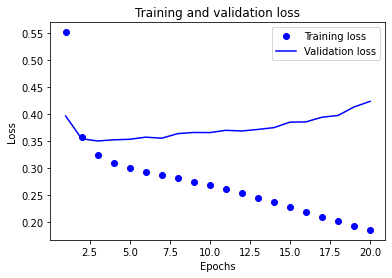

In [26]:
import matplotlib.pyplot as plt

acc = RNN_history_dict['accuracy']
val_acc = RNN_history_dict['val_accuracy']
loss = RNN_history_dict['loss']
val_loss = RNN_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

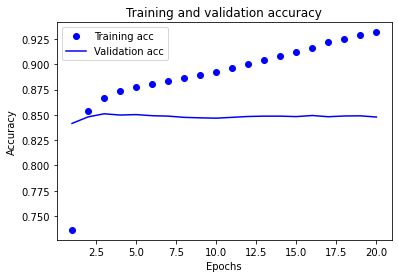

In [27]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 1D CNN 모델

In [28]:
CNN_history_dict = CNN_history.history
print(CNN_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


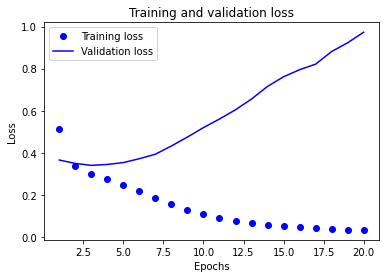

In [29]:
import matplotlib.pyplot as plt

acc = CNN_history_dict['accuracy']
val_acc = CNN_history_dict['val_accuracy']
loss = CNN_history_dict['loss']
val_loss = CNN_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

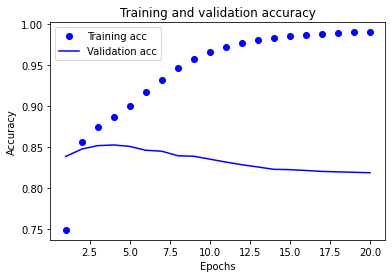

In [30]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling1D() 레이어

In [31]:
GMP_history_dict = GMP_history.history
print(GMP_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


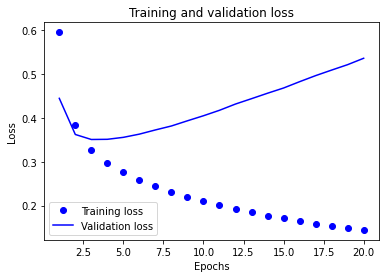

In [32]:
import matplotlib.pyplot as plt

acc = GMP_history_dict['accuracy']
val_acc = GMP_history_dict['val_accuracy']
loss = GMP_history_dict['loss']
val_loss = GMP_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

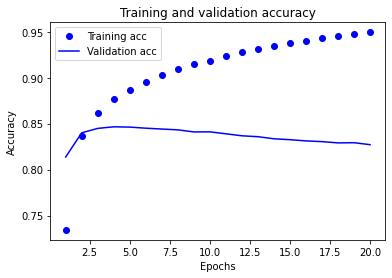

In [33]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Embed 모델 - Google의 Word2Vec 모델

In [34]:
EMB_history_dict = EMB_history.history
print(EMB_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


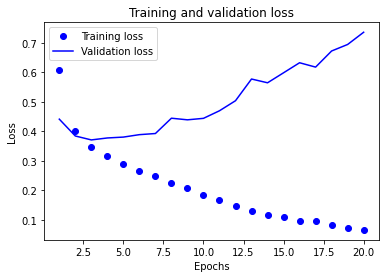

In [35]:
import matplotlib.pyplot as plt

acc = EMB_history_dict['accuracy']
val_acc = EMB_history_dict['val_accuracy']
loss = EMB_history_dict['loss']
val_loss = EMB_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

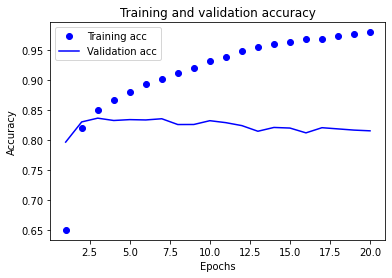

In [36]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 학습된 Embedding 레이어 분석

In [37]:
embedding_layer = RNN_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [38]:
embedding_layer = CNN_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [39]:
embedding_layer = GMP_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [40]:
embedding_layer = EMB_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 300)


# 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [41]:
import os
import gensim
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

/tmp/ipykernel_4376/2158595543.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['컴퓨터']


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)   
노드 본문에서는 실습 환경상 메모리 에러를 막기 위해 300dim의 벡터로 이루어진 300만 개의 단어 벡터를 KeyedVectors.load_word2vec_format 메소드의 limt으로 조건을 주어 가장 많이 사용되는 상위 100만 개만 로딩했다.   
ko.bin은 200dim의 벡터로 이루어진 3만 185개의 단어 데이터이므로 비교적 크지 않아 해당 메소드를 사용하지 않고 단어를 로드했다.


In [42]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_4376/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

### 모델 구성

In [43]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
        

/tmp/ipykernel_4376/3839584803.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_4376/3839584803.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [44]:
vocab_size = 10000
word_vector_dim = 200

RNN_model_ko = keras.Sequential()
RNN_model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
RNN_model_ko.add(keras.layers.LSTM(64))
RNN_model_ko.add(keras.layers.Dense(256, activation='relu'))
RNN_model_ko.add(keras.layers.Dense(1, activation='sigmoid'))

RNN_model_ko.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 2,084,737
Trainable params: 2,084,737
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련 개시

In [45]:
RNN_model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

RNN_history_ko = RNN_model_ko.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
429/429 [==============================] - 5s 8ms/step - loss: 0.4349 - accuracy: 0.7934 - val_loss: 0.3511 - val_accuracy: 0.8438
Epoch 2/10
429/429 [==============================] - 3s 7ms/step - loss: 0.3212 - accuracy: 0.8613 - val_loss: 0.3295 - val_accuracy: 0.8579
Epoch 3/10
429/429 [==============================] - 3s 7ms/step - loss: 0.2794 - accuracy: 0.8821 - val_loss: 0.3283 - val_accuracy: 0.8595
Epoch 4/10
429/429 [==============================] - 3s 7ms/step - loss: 0.2487 - accuracy: 0.8960 - val_loss: 0.3271 - val_accuracy: 0.8604
Epoch 5/10
429/429 [==============================] - 3s 7ms/step - loss: 0.2198 - accuracy: 0.9105 - val_loss: 0.3350 - val_accuracy: 0.8606
Epoch 6/10
429/429 [==============================] - 3s 7ms/step - loss: 0.1937 - accuracy: 0.9225 - val_loss: 0.3688 - val_accuracy: 0.8598
Epoch 7/10
429/429 [==============================] - 3s 7ms/step - loss: 0.1639 - accuracy: 0.9355 - val_loss: 0.4065 - val_accuracy: 0.8584
Epoch 

In [46]:
results = RNN_model_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5749 - accuracy: 0.8478
[0.5748919248580933, 0.8477734327316284]


### Loss, Accuracy 그래프 시각화

In [47]:
RNN_history_dict_ko = RNN_history_ko.history
print(RNN_history_dict_ko.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


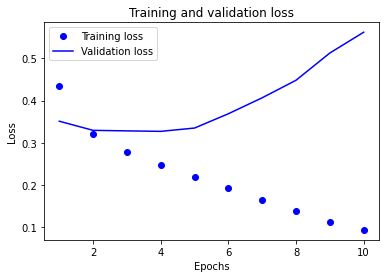

In [48]:
import matplotlib.pyplot as plt

acc = RNN_history_dict_ko['accuracy']
val_acc = RNN_history_dict_ko['val_accuracy']
loss = RNN_history_dict_ko['loss']
val_loss = RNN_history_dict_ko['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

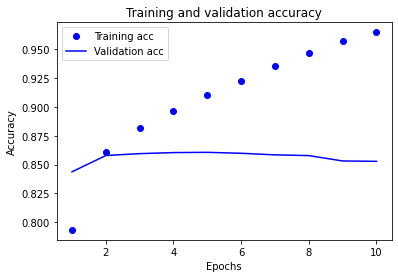

In [49]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [50]:
embedding_layer = RNN_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


LSTM레이어를 사용한 RNN모델, 1차원 CNN모델, GlobalMaxPooling레이어 하나만을 사용한 모델, 구글 Word2Vec를 임베딩한 임베드 모델을 써 보았을 때 RNN모델이 0.8373으로 가장 높은 정확도를 보였다.   
이 RNN모델에 한국어 Word2Vec 임베딩을 활용하니 0.8478정도로 성능이 조금 더 향상되는 모습을 보였다.

# 회고

이번 과제에서도 어김없이 빨간색 경고 메세지를 마주했다. 천천히 살펴보니 ko.bin을 오류없이 로드하기 위해 gensim의 버전을 낮춘 것 때문에 생긴 warning인 듯 했다. 처음 빨간색을 마주했을 땐 구글을 떠도는 나날이 또 반복되나 철렁했는데 일단은 무시해도 괜찮은 메세지임을 깨닫고 가슴을 쓸어내리며 안도했다.
또 코드를 작성하며 예상한대로 한국어 Word2Vec임베딩을 활용했을 때 정확도가 조금이라도 높게 나와주어 하늘에게 감사했다. 제가 제대로 한 게 맞군요!

텍스트 감성분석이라는 주제가 너무도 흥미로워서, 지나온 한 주는 여느때보다 꽤 즐겁게 과제를 수행했다. 보통 본문 내용 중 보충학습 개념으로 참고하라고 걸려있는 링크까지는 자세히 살펴보지 못한채 전체 흐름만 파악하고 넘길때가 많은데, 이번엔 링크 속 내용까지 재미있게 모조리 읽었다. 아이펠에 오기 전까진 상상도 할 수 없던 “인공지능”의 “감성”, “분석”이라는 조합이 인상깊게 다가와서일까 생각이 든다.   
이번 코드의 반환값들 중에도 아주 인상깊은 것이 있다. 한국어 Word2Vec 임베딩을 로드한 후 Word2Vec에서 제공하는 워드 임베딩 벡터들끼리 의미적 유사도가 가까운 것이 서로 가깝게 제대로 학습되어 있는가 확인하기 위해 gensim을 사용해 단어를 하나 주고, 그와 가장 유사한 단어와 그 유사도를 확인하는 과정에서 ‘사랑’과 유사도가 가장 높은 단어로 ‘슬픔’이 나온 것이다. 이는 벡터끼리 유사한 정도를 분석해 오름차순으로 정렬한 결과에 불과하지만 사랑과 가장 유사도가 높다고 컴퓨터가 뱉어낸 것이 슬픔이라니! 결과를 바라보고 있자니 기분이 이상했다.